# Black Box Variational Inference on Diagnostic Classification Models

$\textbf{Motivation behind ELBO cost function}$

The evidence lower bound is a lower bound of the log marginalized joint distribution $p(x, z)$. The value $\log p(x)$ is called the evidence.
$$\log p(x) = \log\left( \int p(x, z) dz\right)$$
$$ = \log \left(\int p(x, z)\frac{q(z)}{q(z)} dz\right)$$
$$ = \log \left(E_q\left[\frac{p(x, z)}{q(z)}\right]\right)$$
$$ \geq E_q[\log p(x, z)] - E_q[\log q(z)] \quad \text{(ELBO)}$$
The last term obtained via Jensen's inequality and linearity of expectation. It is referred to as the evidence lower bound. The ELBO shows up in variational inference as an alternative cost function to the KL divergence.
$$KL(q||p) = E_q\left[\log\left(\frac{q(z)}{p(z|x)}\right)\right]$$
$$ = E_q[\log q(z)] - E_q[\log p(z|x)]$$
$$ = E_q[\log q(z)] - E_q[\log p(x, z)] + E_q[\log p(x)]$$
$$ = -\text{ELBO} + \log p(x)$$
Since the goal of variational inference is to optimize the parameters of $q$, maximizing the ELBO with respect to $q$ is equivalent to minimizing the KL divergence with respect to $q$.

$\textbf{Noisy Gradient of the ELBO}$

The minimizer of the ELBO does not always have an analytical form. Instead, gradient ascent is used to find the maximizer. An unbiased estimator of the gradient is obtained by sampling from variational distirbution $q$.
The gradient of the ELBO is 
$$\nabla_{\lambda}L = E_q[\nabla_{\lambda}\log q(z|\lambda) (\log p(x, z) - \log q(z|\lambda))]$$
Assume each latent variable $z$ is governed by independent variational distributions such that $q(z|\lambda) = \prod_{i = 1}^n q(z_i|\lambda_i)$. Equation 5 from (Ranganath et. al., 2013) gives the Rao-Blackwellized estimator of the gradient for individual $\lambda_i$.
$$\nabla_{\lambda_i}L = E_{q_{(i)}}[\nabla_{\lambda_i}\log q(z_i|\lambda_i)(\log p_i(x, z_{(i)}) - \log q(z_i|\lambda_i))]$$
$E_{q_{(i)}}$ is the expectation with respect to the markov blanket of $z_i$, or the variables that depend on $z_i$, and $p_i(x, z_{(i)})$ is the terms of the join distribution that depend on $x$ and $z_i$.

$\textbf{Diagnostic Classification Model (DCM)}$

In this problem setting, there are $I$ items on an assesment, and each item measures up to $A$ attributes. Each latent class $c$ has an attribute profile $Z_c = [z_{c1}, ..., z_{cA}] \in \{0, 1\}^A$ where $z_{ca} = 0$ indicates that the $a$-th attribute is not mastered and $z_{ca} = 1$ indicates that the $a$-th attribute is mastered in latent class $c$. 

$Q \in \{0, 1\}^{I \times A}$ is called the Q matrix and $q_{ia}$ indicates whether question $i$ measures mastery of attribute $a$. 0 indicates that the attribute is not measured and 1 indicates that it is measured.

$\Delta_i = (\delta_{i1}, ..., \delta_{iL})^T$ is the feature matrix for item $i$, where each row is indexed by an attribute profile and the columns are the attributes and all the interactions of attributes measured by an item on the assesment. 1 indicates that the attributes in the interaction term are all mastered in the attributes profile. 0 indicates that at least 1 attribute in the interaction is not mastered in the attribute profile.

For example, consider that item $i$ measures mastery of 2 attributes. There are $L = 4$ possible attribute profiles (00, 01, 10, 11) corresponding to no masteries, mastering attribute 1, mastering attribute 2, and mastering both attributes. There are 4 features in $\Delta_i$ (00, 01, 10, 11) corresponding to intercept, main effect of attribute 1 mastery, main effect of attribute 2 mastery, and interaction effect.

$$
\begin{array}{ccccc} 
   & \textbf{00} & \textbf{01} & \textbf{10} & \textbf{11}\\
\textbf{00} & 1 & 0 & 0 & 0\\
\textbf{01} & 1 & 1 & 0 & 0\\
\textbf{10} & 1 & 0 & 1 & 0\\
\textbf{11} & 1 & 1 & 1 & 1
\end{array}
$$

The DCM models $\pi_{ic} = P(Y_{ic} = 1 | Z_c)$, the probability of a respondent with attribute profile $Z_c$ answering the $i$-th item correctly.

Let $\sigma$ be the sigmoid function, $\sigma(x) = \frac{1}{1 + e^{-x}}$
$$\pi_{ic} = \sigma(\beta_i^T\delta_{ic})$$
$$P(Y_{ic} = y_{ic} | Z_c) = (\pi_{ic})^{y_{ic}} \cdot (1 - \pi_{ic})^{1 - y_{ic}}$$
$$ = \sigma((2y_{ic} - 1)\beta_i^T\delta_{ic}) \quad \text{(Only true when $y_{ic} \in \{0, 1\}$)}$$

## Naive Black Box 

In this section black box variational inference will be used to estimate the parameters of a DCM model. Data is generated according to the probability model shown below. 

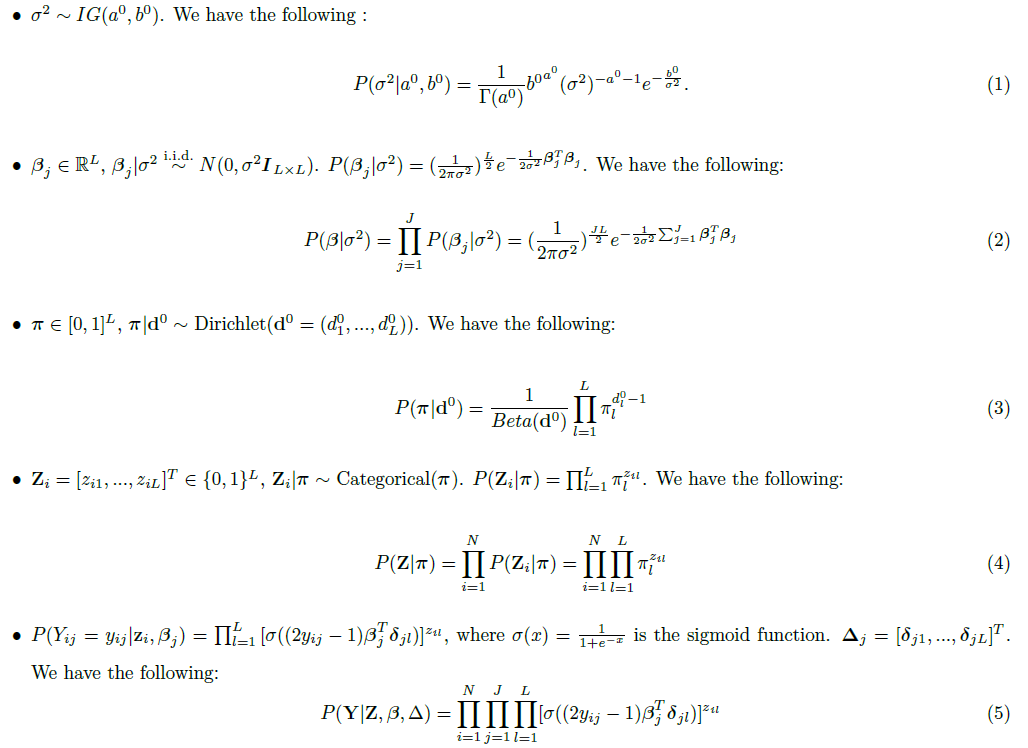

In [1]:
display("image/png", read("DCM probability model.png"))

The joint distribution is 
$$P(Y, Z, \beta, \pi, \sigma^2 | \Delta, d^0, a^0, b^0) = P(Y|Z,\beta,\Delta)P(Z|\pi)P(\pi|d^0)P(\beta|\sigma^2)P(\sigma^2|a^0,b^0)$$
$$ = \prod_{i = 1}^N\prod_{j = 1}^J\prod_{l = 1}^L [\sigma((2y_{ij} - 1)\beta_j^T\delta_{jl})]^{z_{il}} \cdot \prod_{i = 1}^N\prod_{l = 1}^L \pi_l^{z_{il}} \cdot \frac{1}{\text{Beta}(d^0)}\prod_{l = 1}^L \pi_l^{d^0_l - 1} \cdot \left(\frac{1}{2\pi\sigma^2}\right)^{\frac{JL}{2}}e^{-\frac{1}{2\sigma^2}\sum_{j = 1}^J\beta_j^T\beta_j} \cdot \frac{1}{\Gamma(a^0)}(b^0)^{a^0}(\sigma^2)^{-a^0 - 1}e^{-\frac{b^0}{\sigma^2}}$$

The variational distribution follows the mean field family
$$Q(Z, \beta, \pi, \sigma^2) = q_1(Z)q_2(\beta)q_3(\pi)q_4(\sigma^2)$$
$$ = \left(\prod_{i = 1}^Nq_{1i}(Z_i)\right)\left(\prod_{j = 1}^Jq_{2j}(\beta_j)\right)q_3(\pi)q_4(\sigma^2)$$
$$Z_i \sim \text{Categorical}(\pi_i^*) \quad \beta_j \sim N(\mu_j^*, V_j^*) \quad \pi \sim \text{Dirichlet}(d^*) \quad \sigma^2 \sim IG(a^*, b^*)$$

$\textbf{Noisy Gradient of }q_{1i}(Z_i)$

Since the parameters of $q_{1i}(Z_i)$ are constrained by $\sum_{l = 1}^L\pi_{il}^* = 1$, there are only $L-1$ degrees of freedom. Let $\pi_{iL}^* = 1 - \sum_{l = 1}^{L-1}\pi_{il}^*$.

$$
\begin{aligned}
\log(q_{1i}(Z_i)) & = \sum_{l = 1}^{L-1}z_{il}\log(\pi_{il}^*) + z_{iL}\log(1 - \sum_{l = 1}^{L-1}\pi_{il}^*)\\
\nabla_{\pi_{il}^*}\log(q_{1i}(Z_i)) & = \frac{z_{il}}{\pi_{il}^*} - \frac{z_{iL}}{1 - \sum_{l = 1}^{L-1}\pi_{il}^*}\\
\log(p(Y, Z_{(i)})) & = \sum_{j = 1}^J\sum_{l = 1}^Lz_{il}\log(\sigma((2y_{ij} - 1)\beta_j^T\delta_{jl})) + \sum_{l = 1}^Lz_{il}\log(\pi_l)
\end{aligned}
$$
Note that $\pi_l$ are latent variables in the probability model different from $\pi_{il}^*$ which are the parameters of the variational distribution. 

The gradient is approximated by sampling 

$$Z_{im} \sim q_{1i}(Z_i|(\pi_i^*)^{\text{(old)}}), \quad \beta_{jm} \sim q_{2j}(\beta_j|(\mu_j^*, V_j^*)^{\text{(old)}}), \quad \pi_m \sim q_4(\pi|(d^*)^{\text{(old)}}), \quad \text{for } m = 1, 2, ..., M$$

and taking the following average

$$
\begin{aligned}
\nabla_{\pi_{il}^*}L & = E_{q_{1i}(Z_i)}[\nabla_{\pi_{il}^*}\log(q_{1i}(Z_i))\cdot(\log(p(Y,Z_{(i)})) - \log(q_{1i}(Z_i)))]\\
 & \approx \frac{1}{M}\sum_{m = 1}^M\left[\left(\frac{z_{iml}}{\pi_{il}^*} - \frac{z_{imL}}{1 - \sum_{l = 1}^{L-1}\pi_{il}^*}\right)\cdot\left(\sum_{j = 1}^J\sum_{l = 1}^Lz_{iml}\log(\sigma((2y_{ij} - 1)\beta_{jm}^T\delta_{jl}))\right.\right.\\
 & \left.\left.+ \sum_{l = 1}^Lz_{iml}\log(\pi_{ml}) - \sum_{l = 1}^{L-1}z_{iml}\log(\pi_{il}^*) - z_{imL}\log(1 - \sum_{l = 1}^{L-1}\pi_{il}^*)\right)\right]
\end{aligned}
$$

Let $S = \{\pi : \sum_{l = 1}^L \pi_l = 1, \forall_{l \in [L]} \pi_l \geq 0\}$ be the feasible set of solutions to the gradient ascent problem. Since gradient ascent updates can move the parameters outside of the feasible set, at each step the solution will be projected back onto the feasible set.
$$
(\pi^*_i)^{(t+1)} = Proj_{S}((\pi^*_i)^{(t)} + t \cdot \nabla_{\pi^*_{i}}L)
$$


Projection onto $S$ is equivalent to orthogonal projection onto the unit simplex. Let $\rho^{t+1} = (\pi^*_i)^{(t)} + t \cdot \nabla_{\pi^*_{i}}L$ be the $(t+1)$-th gradient ascent update. 
$$
\begin{aligned}
(\pi^*_i)^{(t+1)} & = Proj_{S}(\rho^{t+1})\\
 & = \arg\min_{x \in S} \frac{1}{2}||x - \rho^{t+1}||_2^2
\end{aligned}
$$
Let $(\cdot)_{+}$ be projection onto the non-negative real numbers.

Minimize the Lagrangian:
$$
\begin{aligned}
L(x, u) & = \frac{1}{2}||x - \rho^{t+1}||_2^2 + u(\sum_{i = 1}^L x_i - 1)\\
 & = \sum_{i = 1}^L \frac{1}{2}(x_i - \rho^{t+1}_i)^2 + ux_i - u\\
\arg\inf_{x \in S} L(x, u) & = \left\{(\rho^{t+1}_i - u)_{+}\right\}_{i = 1}^L
\end{aligned}
$$
Solve for $u$ by satisfying KKT conditions:
$$
\begin{aligned}
h(u) = \sum_{i = 1}^L (\rho^{t+1}_i - u)_{+} - 1 = 0
\end{aligned}
$$
Although $h$ is piecewise linear, we can still use Newton's method to iteratively solve for $h(u) = 0$ by defining $h'(u) = \sum_{i = 1}^L -1_{\{\rho^{t+1}_i - u > 0\}}$ and using the update rule $u_1 = u_0 - \frac{h(u_0)}{h'(u_0)}$

$\textbf{Noisy Gradient of }q_{2j}(\beta_j)$

We parameterize $q_{2j}$ with $(V_j^*)^{-1}$ instead of $V_j^*$ for easier and more efficient gradient updates. Furthermore, to ensure that all gradient updates remain within the positive semi definite cone, let $(V_j^*)^{-1} = C^*_jC^{*T}_j$ where $C^*_j$ is the lower triangular Cholesky factor of the Cholesky decomposition of $(V_j^*)^{-1}$. We will update $C^*_j$ via noisy gradient descent. 

Let $k_j$ be the length of $\beta_j$ or the number of features.

$$
\begin{aligned}
\log(q_{2j}(\beta_j)) & = -\frac{k_j}{2}\log(2\pi) - \frac{1}{2}\log(|V_j^*|) - \frac{1}{2}(\beta_j - \mu_j^*)^T(V_j^*)^{-1}(\beta_j - \mu_j^*)\\
\nabla_{\mu_j^*}\log(q_{2j}(\beta_j)) & = (V_j^*)^{-1}(\beta_j - \mu_j^*)\\
\nabla_{(V_j^*)^{-1}}\log(q_{2j}(\beta_j)) & = \frac{1}{2}V_j^* - \frac{1}{2}(\beta_j - \mu_j^*)(\beta_j - \mu_j^*)^T\\
\frac{d\log(q_{2j}(\beta_j))}{d\text{ vech}(C^*_j)} & = \frac{d\log(q_{2j}(\beta_j))}{d\text{ vec}((V_j^*)^{-1})} \cdot \frac{d\text{ vec}((V_j^*)^{-1})}{d\text{ vech}(C^*_j)}\\
 & = \text{vec}\left(\nabla_{(V_j^*)^{-1}}\log(q_{2j}(\beta_j))\right) \cdot \frac{d\text{ vec}((V_j^*)^{-1})}{d\text{ vech}(C^*_j)}\\
 & = \text{vec}\left(\nabla_{(V_j^*)^{-1}}\log(q_{2j}(\beta_j))\right) \cdot \left[C^*_j\otimes I + I\otimes C^*_j K_{k_j}\right]D_{k_j}\\
 & = \text{vec}\left(\frac{1}{2}V_j^* - \frac{1}{2}(\beta_j - \mu_j^*)(\beta_j - \mu_j^*)^T\right) \cdot \left[C^*_j\otimes I + I\otimes C^*_j K_{k_j}\right]D_{k_j}\\
\log(p(Y, \beta_{(j)})) & = \sum_{i = 1}^N\sum_{l = 1}^Lz_{il}\log(\sigma((2y_{ij} - 1)\beta_j^T\delta_{jl})) - \frac{1}{2\sigma^2}\beta_j^T\beta_j
\end{aligned}
$$
**vec** and **vech** are the [vectorization](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) and [half vectorization](https://en.wikipedia.org/wiki/Vectorization_(mathematics)#Half-vectorization) operations for matricies. $\otimes$ is the kronecker product. $K_{k_j}$ is the [commutation matrix](https://en.wikipedia.org/wiki/Commutation_matrix) for the vectorization of a $k_j$ by $k_j$ matrix. 

i.e. If $A \in R^{k_j \times k_j}$ then $K_{k_j}\text{vec}(A) = \text{vec}(A^T)$

$D_{k_j}$ is the duplication matrix for a lower triangular $k_j$ by $k_j$ matrix.

i.e. If $A$ is a lower triangular $k_j$ by $k_j$ matrix then $D_{k_j}\text{vech}(A) = \text{vec}(A)$ (Note: This is not the same as the duplication matrix for symmetric A)

The gradient is approximated by sampling
$$Z_{im} \sim q_{1i}(Z_i|(\pi_i^*)^{\text{(old)}}), \quad \beta_{jm} \sim q_{2j}(\beta_j|(\mu_j^*, V_j^*)^{\text{(old)}}), \quad \sigma_m \sim q_3(\sigma|(a^*, b^*)^{\text{(old)}}), \quad \text{for } m = 1, 2, ..., M$$

and taking the following averages

$$
\begin{aligned}
\nabla_{\mu_{j}^*}L & = E_{q_{2j}(\beta_j)}[\nabla_{\mu_{j}^*}\log(q_{2j}(\beta_j))\cdot(\log(p(Y,\beta_{(j)})) - \log(q_{2j}(\beta_j)))]\\
 & \approx \frac{1}{M}\sum_{m = 1}^M\left[(V_j^*)^{-1}(\beta_{jm} - \mu_j^*) \cdot \left(\sum_{i = 1}^N\sum_{l = 1}^Lz_{iml}\log(\sigma((2y_{ij} - 1)\beta_{jm}^T\delta_{jl})) - \frac{1}{2\sigma_m^2}\beta_{jm}^T\beta_{jm}\right.\right.\\
 & \left.\left.+ \frac{1}{2}\log(|V_j^*|) + \frac{1}{2}(\beta_{jm} - \mu_j^*)^T(V_j^*)^{-1}(\beta_{jm} - \mu_j^*)\right)\right]\\
\frac{dL}{d\text{ vech}(C_j)} & = E_{q_{2j}(\beta_j)}\left[\frac{d\log(q_{2j}(\beta_j))}{d\text{ vech}(C_j)}\cdot(\log(p(Y,\beta_{(j)})) - \log(q_{2j}(\beta_j)))\right]\\
 & \approx \frac{1}{M}\sum_{m = 1}^M\left[\text{vec}\left(\frac{1}{2}V_j^* - \frac{1}{2}(\beta_{jm} - \mu_j^*)(\beta_{jm} - \mu_j^*)^T\right) \cdot \left[C_j\otimes I + I\otimes C_j K_{k_j}\right]D_{k_j}\right.\\ 
 & \left.\cdot \left(\sum_{i = 1}^N\sum_{l = 1}^Lz_{iml}\log(\sigma((2y_{ij} - 1)\beta_{jm}^T\delta_{jl})) - \frac{1}{2\sigma_m^2}\beta_{jm}^T\beta_{jm} + \frac{1}{2}\log(|V_j^*|) + \frac{1}{2}(\beta_{jm} - \mu_j^*)^T(V_j^*)^{-1}(\beta_{jm} - \mu_j^*)\right)\right]
\end{aligned}
$$

In [1]:
using LinearAlgebra, Distributions, Combinatorics, Random, Kronecker
include("BBVI_utils.jl")

In [2]:
struct DCMObs{T <: Int}
    # data
    Y          :: Matrix{T}
    Q          :: Matrix{T}
    D          :: Vector{Matrix{T}}
end

function DCMObs(
    Y::Matrix{T}, 
    Q::Matrix{T}) where T <: Int
    D = generate_delta(Q)
    DCMObs(Y, Q, D)
end

DCMObs

In [3]:
struct DCModel{T <: AbstractFloat}
    # data
    obs             :: DCMObs
    # Prior distribution parameters
    d0              :: Vector{T}
    a0              :: T
    b0              :: T
    # Variational distribution parameters
    pi_star         :: Vector{Vector{T}}
    mu_star         :: Vector{Vector{T}}
    Vinv_star       :: Vector{Matrix{T}}
    d_star          :: Vector{T}
    a_star          :: T
    b_star          :: T
    # Number of samples for noisy gradient
    M               :: Int
    # Preallocated storage for samples from variational distribution
    Z_sample        :: Vector{Vector{Vector{Int}}}
    beta_sample     :: Vector{Vector{Vector{T}}}
    pi_sample       :: Vector{Vector{T}}
    sigma2_sample   :: Vector{T}
    # Preallocated storage for noisy gradient descent calculations
    storage_L       :: Vector{T}
    storage_L2      :: Vector{T}
    storage_L3      :: Vector{T}
    storage_LL      :: Matrix{T}
    storage_LL2     :: Matrix{T}
    storage_LL3     :: Matrix{T}
    # Preallocated storage for matrix vectorization operations
    storage_comm    :: Matrix{T}
    storage_dup     :: Matrix{T}
    storage_Lsqr    :: Vector{T}
    storage_Lsqr2   :: Vector{T}
    storage_L2L2    :: Matrix{T}
    storage_C       :: Matrix{T}
    storage_gradC   :: Vector{T}
    # Preallocated Identity matrix
    I_LL            :: Matrix{T}
end

function DCModel(
    obs             :: DCMObs,
    d0              :: Vector{T},
    a0              :: T,
    b0              :: T,
    M               :: Int) where T <: AbstractFloat
    N, J, L = size(obs.Y, 1), size(obs.Y, 2), size(obs.D[1], 1)
    # Initialize variational distribution parameters
    pi_star = Vector{Vector{T}}(undef, N)
    for i in 1:N
        pi_star[i] = ones(L) ./ L
    end
    mu_star = Vector{Vector{T}}(undef, J)
    Vinv_star = Vector{Matrix{T}}(undef, J)
    for j in 1:J
        num_features = size(obs.D[j], 2)
        mu_star[j] = zeros(num_features)
        Vinv_star[j] = Matrix(1.0I, num_features, num_features)
    end
    d_star = ones(L) ./ L
    a_star = 3.0
    b_star = 3.0
    # Preallocate space for samples from variational distribution
    Z_sample = Vector{Vector{Vector{Int}}}(undef, N)
    for i in 1:N
        Z_sample[i] = Vector{Vector{Int}}(undef, M)
        for m in 1:M
            Z_sample[i][m] = Vector{Int}(undef, L)
        end
    end
    beta_sample = Vector{Vector{Vector{T}}}(undef, J)
    for j in 1:J
        beta_sample[j] = Vector{Vector{T}}(undef, M)
        num_features = size(obs.D[j], 2)
        for m in 1:M
            beta_sample[j][m] = Vector{T}(undef, num_features)
        end
    end
    pi_sample = Vector{Vector{T}}(undef, M)
    for m in 1:M
        pi_sample[m] = Vector{T}(undef, L)
    end
    sigma2_sample = Vector{T}(undef, M)
    # Preallocate storage for noisy gradient descent calculations
    storage_L = Vector{T}(undef, L)
    storage_L2 = similar(storage_L)
    storage_L3 = similar(storage_L)
    storage_LL = Matrix{T}(undef, L, L)
    storage_LL2 = similar(storage_LL)
    storage_LL3 = similar(storage_LL)
    # Preallocate storage for matrix vectorization operations
    storage_comm = Matrix{T}(undef, L^2, L^2)
    storage_dup = Matrix{T}(undef, L^2, Int(L*(L+1)/2))
    storage_Lsqr = Vector{T}(undef, L^2)
    storage_Lsqr2 = Vector{T}(undef, L^2)
    storage_L2L2 = Matrix{T}(undef, L^2, L^2)
    storage_C = Matrix{T}(undef, L, L)
    storage_gradC = Vector{T}(undef, Int(L*(L+1)/2))
    # Preallocate Identity matrix
    I_LL = Matrix{T}(I, L, L)
    # Initialize DCModel object
    DCModel(obs, d0, a0, b0, 
    pi_star, mu_star, Vinv_star, d_star, a_star, b_star, M,
    Z_sample, beta_sample, pi_sample, sigma2_sample,
    storage_L, storage_L2, storage_L3, storage_LL, storage_LL2, storage_LL3,
    storage_comm, storage_dup, storage_Lsqr, storage_Lsqr2, storage_L2L2, storage_C, storage_gradC,
    I_LL)
end

DCModel

In [4]:
function sample_variational_distribution(
    model           :: DCModel;
    sample_Z        :: Bool = false,
    sample_β        :: Bool = false,
    sample_pi       :: Bool = false,
    sample_sigma2   :: Bool = false)
    M = model.M
    obs = model.obs
    N, J, L = size(obs.Y, 1), size(obs.Y, 2), size(obs.D[1], 1)
    if sample_Z
        for i in 1:N
            # Create variational distribution from model parameters for each Z_i
            Z_i_variational_distribution = Multinomial(1, model.pi_star[i])
            # Populate preallocated arrays with samples from variational distribution
            rand!(Z_i_variational_distribution, model.Z_sample[i])
        end
    end
    if sample_β
        for j in 1:J
            len_beta = length(model.beta_sample[j][1])
            # Copy V inverse into preallocated space to perform matrix inverse
            V_j = view(model.storage_LL, 1:len_beta, 1:len_beta)
            copy!(V_j, model.Vinv_star[j])
            # In place cholesky decomposition of V inverse
            LAPACK.potrf!('U', V_j)
            # In place matrix inverse from choesky decomposition
            LAPACK.potri!('U', V_j)
            LinearAlgebra.copytri!(V_j, 'U')
            # Create variational distribution from model parameters for each β_j
            beta_j_variational_distribution = MvNormal(model.mu_star[j], V_j)
            # Populate preallocated arrays with samples from variational distribution
            rand!(beta_j_variational_distribution, model.beta_sample[j])
        end
    end
    if sample_pi
        # Create variational distribution from model parameters for pi
        pi_variational_distribution = Dirichlet(model.d_star)
        # Populate preallocated arrays with samples from variational distribution
        rand!(pi_variational_distribution, model.pi_sample)
    end
    if sample_sigma2
        # Create variational distribution from model parameters for σ²
        sigma2_variational_distribution = InverseGamma(model.a_star, model.b_star)
        # Populate preallocated array with samples from variational distribution
        rand!(sigma2_variational_distribution, model.sigma2_sample)
    end
    nothing
end

sample_variational_distribution (generic function with 1 method)

In [5]:
"""
    update_pi_star(Y, D, Z_sample, beta_sample, pi_sample, pi_star_old, 
                    step, tol = 1e-6, maxiter = 100000, verbose = true)

Find the parameters of the variational distribution of Z_i that maximize 
the ELBO via gradient descent. The gradient is an expectation which is 
appoximated from the inputs `Z_sample`, `beta_sample`, and `pi_sample` 
which are sampled from the variational distribution. The same sample is 
used for every gradient descent update for the sake of computational 
efficiency. `pi_star_old` are the parameters that are updated in place.

"""
function update_pi_star(
    model           :: DCModel;
    step            :: T = 1e-2,
    tol             :: T = 1e-6,
    maxiter         :: Int = 100000,
    verbose         :: Bool = true
) where T <: AbstractFloat
    # TODO: Optimize allocation efficiency
    obs = model.obs
    Y, D = obs.Y, obs.D
    Z_sample, beta_sample, pi_sample = model.Z_sample, model.beta_sample, model.pi_sample
    pi_star_old = model.pi_star
    N, J, L = size(Y, 1), size(Y, 2), size(D[1], 1)
    M = model.M
    # Sample β and pi from variational distribution, these sample do not change while parameters of q(Z) are being updated
    sample_variational_distribution(model, sample_β = true, sample_pi = true)
    # Fully update parameters of each Z_i using noisy gradients before moving to update parameters of next Z_i
    for i in 1:N
        # Perform gradient descent update of i-th π*    
        for iter in 1:maxiter
            # Sample Z with updated π*
            sample_variational_distribution(model, sample_Z = true)
            pi_star_old_i = pi_star_old[i]
            log_pi_star_i = log.(pi_star_old_i)
            grad_L = zeros(L - 1)
            # Rao Blackwellized ELBO
            ELBO = 0
            # Calculate the gradient estimate of the m-th sample
            for m in 1:M
                z_im = Z_sample[i][m]
                # Calculate gradient of log(q_1i(Z_i)) w.r.t. π*_i
                grad_log_q = z_im[1:(L-1)] ./ pi_star_old_i[1:(L-1)] .- z_im[L]/pi_star_old_i[L]
                # Calculate log(p(Y, Z_(i)))
                log_prob_YZ = 0
                for j in 1:J
                    log_prob_YZ += dot(z_im, log.(sigmoid.((2*Y[i,j] - 1) .* (D[j] * beta_sample[j][m]))))
                end
                log_prob_YZ += dot(z_im, log.(pi_sample[m]))
                # Calculate log(q_1i(Z_i))
                log_q = dot(z_im, log_pi_star_i)
                # Update average gradient
                grad_L .= (m - 1)/m .* grad_L + 1/m .* grad_log_q .* (log_prob_YZ - log_q)
                # Update ELBO estimator
                ELBO = (m-1)/m * ELBO + 1/m * (log_prob_YZ - log_q)
            end
            # Print ELBO, parameter and gradient if verbose
            if verbose
                println("ELBO: $ELBO")
                println("π*_i: $pi_star_old_i")
                println("gradient: $grad_L")
            end
            # Stop condition
            if abs2(norm(grad_L)) <= tol
                break
            end
            # Update with one step
            pi_star_old_i[1:(L-1)] .+= step * grad_L
            pi_star_old_i[L] = 1 - sum(pi_star_old_i[1:(L-1)])
            # Project back into feasible set if needed
            if(any(pi_star_old_i .< 0))
                project_to_unit_simplex!(pi_star_old_i)
            end
        end
    end
end

update_pi_star

In [12]:
function update_mu_star_V_star(
    model           :: DCModel;
    step            :: T,
    tol             :: T = 1e-6,
    maxiter         :: Int = 100000,
    verbose         :: Bool = true
) where T <: AbstractFloat
    obs = model.obs
    Y, D = Matrix{T}(obs.Y), Vector{Matrix{T}}(obs.D)
    Z_sample, beta_sample, sigma2_sample = model.Z_sample, model.beta_sample, model.sigma2_sample
    mu_star_old, Vinv_star_old = model.mu_star, model.Vinv_star
    N, J, L = size(Y, 1), size(Y, 2), size(D[1], 1)
    M = model.M
    # Sample Z and sigma^2, these samples do not update while mu and V are being updated
    sample_variational_distribution(model, sample_Z = true, sample_sigma2 = true)
    # Fully update parameters of each β_j using noisy gradients before moving to update parameters of next β_j
    for j in 1:J
        # Perform gradient descent update of mu_j and V_j
        len_beta = length(beta_sample[j][1])
        # Assign storage for gradient terms
        # Memory assigned from preallocated storage
        # Memory has to be strided (equal stride between memory addresses) to work with BLAS and LAPACK 
        # (important for vectorized matricies to be strided if we want to use them for linear algebra)
        # Matricies are stored column major in Julia, so memory is assigned by column left to right
        grad_mu_L = view(model.storage_L, 1:len_beta)
        grad_C_L = view(model.storage_LL2, 1:len_beta, 1:len_beta) 
        vech_grad_C_L = view(grad_C_L, [len_beta*(j-1) + i for j in 1:len_beta for i in j:len_beta]) # Uses same memory as grad_C_L
        grad_mu_log_q = view(model.storage_L2, 1:len_beta)
        grad_Vinv_log_q = view(model.storage_LL3, 1:Int(L/len_beta):L, 1:len_beta)
        vec_grad_Vinv_log_q = view(grad_Vinv_log_q, 1:len_beta^2) # Uses same memory as grad_Vinv_log_q
        # Assign storage for calculating intermediate terms for gradient
        V_star_old_j = view(model.storage_LL, 1:len_beta, 1:len_beta)
        beta_minus_mu = view(model.storage_L3, 1:len_beta)
        C_star_old_j = view(model.storage_C, 1:len_beta, 1:len_beta)
        vech_C_star_old_j = view(C_star_old_j, [len_beta*(j-1) + i for j in 1:len_beta for i in j:len_beta]) # Uses same memory as C_star_old_j
        fill!(C_star_old_j, 0)
        storage_kron_prod = view(model.storage_L2L2, 1:len_beta^2, 1:len_beta^2)
        storage_len_beta_sqr = view(model.storage_Lsqr, 1:len_beta^2)
        storage_len_beta_sqr2 = view(model.storage_Lsqr2, 1:len_beta^2)
        storage_gradC = view(model.storage_gradC, 1:Int(len_beta*(len_beta+1)/2))
        # Generate commutation and duplication matrix
        comm_j = view(model.storage_comm, 1:len_beta^2, 1:len_beta^2)
        dup_j = view(model.storage_dup, 1:len_beta^2, 1:Int(len_beta*(len_beta+1)/2))
        get_comm!(comm_j, len_beta)
        get_dup!(dup_j, len_beta)
        # Generate len_beta by len_beta identity matrix
        I_j = view(model.I_LL, 1:len_beta, 1:len_beta)
        for iter in 1:maxiter
            # Sample β from variational distribution
            sample_variational_distribution(model, sample_β = true)
            fill!(grad_mu_L, 0)
            fill!(grad_C_L, 0)
            mu_star_old_j = mu_star_old[j]
            Vinv_star_old_j = Vinv_star_old[j]
            # Copy V inverse into storage
            copy!(V_star_old_j, Vinv_star_old_j)
            # Perform cholesky decomposition on V* inverse
            # After this step, the lower triangle of V_star_old_j will contain the lower triangular cholesky factor of V* inverse
            LAPACK.potrf!('L', V_star_old_j)
            # Calculate log|V_j| from diagonal of cholesky decomposition
            logdet_V_j = 0
            for b in 1:len_beta
                logdet_V_j -= 2 * log(V_star_old_j[b, b])
            end
            # Copy lower triangular cholesky factor into preallocated storage
            for k in 1:len_beta
                for l in 1:k
                    C_star_old_j[k, l] = V_star_old_j[k, l]
                end
            end
            # Perform in place matrix inverse on positive definite V* inverse matrix to get V*
            LAPACK.potri!('L', V_star_old_j)
            LinearAlgebra.copytri!(V_star_old_j, 'L')
            ELBO = 0
            # Calculate the gradient estimate of the m-th sample
            for m in 1:M
                beta_jm = beta_sample[j][m]
                fill!(grad_mu_log_q, 0)
                # grad_mu_log_q = Vinv_star * β_jm
                BLAS.gemv!('N', T(1), Vinv_star_old_j, beta_jm, T(1), grad_mu_log_q)
                # grad_mu_log_q = Vinv_star * β_jm - Vinv_star * mu_star_j
                BLAS.gemv!('N', T(-1), Vinv_star_old_j, mu_star_old_j, T(1), grad_mu_log_q)                
                # grad_Vinv_log_q = 1/2(V_star_j - β_jm * β_jm^T)
                mul!(grad_Vinv_log_q, beta_jm, beta_jm')
                grad_Vinv_log_q .-= V_star_old_j
                grad_Vinv_log_q .*= -1/2
                # storage_kron_prod = I ⊗ C_j
                collect!(storage_kron_prod, kronecker(I_j, C_star_old_j))
                # storage_len_beta_sqr = (I ⊗ C_j)'vec(grad_Vinv_log_q)
                BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_Vinv_log_q, T(1), fill!(storage_len_beta_sqr, 0))
                # storage_kron_prod = C_j ⊗ I
                collect!(storage_kron_prod, kronecker(C_star_old_j, I_j))
                # storage_len_beta_sqr2 = (C_j ⊗ I)'vec(grad_Vinv_log_q)
                BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_Vinv_log_q, T(1), fill!(storage_len_beta_sqr2, 0))
                # storage_len_beta_sqr2 = ((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_Vinv_log_q)
                BLAS.gemv!('T', T(1), comm_j, storage_len_beta_sqr, T(1), storage_len_beta_sqr2)
                # storage_gradC = D'((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_Vinv_log_q)
                BLAS.gemv!('T', T(1), dup_j, storage_len_beta_sqr2, T(1), fill!(storage_gradC, 0))
                # Calculate log(p(Y, β_(j)))
                log_prob_Ybeta = 0
                for i in 1:N
                    fill!(model.storage_L3, 0)
                    BLAS.gemv!('N', (2*Y[i,j] - 1), D[j], beta_jm, T(1), model.storage_L3)
                    log_prob_Ybeta += dot(Z_sample[i][m], log.(sigmoid.(model.storage_L3)))
                end
                log_prob_Ybeta -= 1/(2 * sigma2_sample[m]) * dot(beta_jm, beta_jm)
                beta_minus_mu .= beta_jm
                beta_minus_mu .-= mu_star_old_j
                log_q = -len_beta/2 * log(2 * pi) - 1/2 * logdet_V_j - 1/2 * dot(beta_minus_mu, grad_mu_log_q)
                # Update average gradient
                grad_mu_L .= (m - 1)/m .* grad_mu_L + 1/m .* grad_mu_log_q .* (log_prob_Ybeta - log_q)
                vech_grad_C_L .= (m - 1)/m .* vech_grad_C_L + 1/m .* storage_gradC .* (log_prob_Ybeta - log_q)
                # Update ELBO estimator
                ELBO = (m-1)/m * ELBO + 1/m * (log_prob_Ybeta - log_q)
            end
            # Print ELBO, parameter and gradient if verbose
            if verbose
                println("ELBO: $ELBO")
                println("mu*_$j: $mu_star_old_j")
                println("gradient mu: $grad_mu_L")
                println("C*_$j: $C_star_old_j")
                println("gradient C: $grad_C_L")
            end
            # Stop condition TODO: update to more appropriate stop condition
            if abs2(norm(grad_mu_L)) + abs2(norm(grad_C_L)) <= tol
                break
            end
            # Update mu and C with one step
            mu_star_old_j .+= step .* grad_mu_L
            vech_C_star_old_j .+= step .* vech_grad_C_L
            # Set Vinv_star_old_j = C * C'
            BLAS.gemm!('N', 'T', T(1), C_star_old_j, C_star_old_j, T(1), fill!(Vinv_star_old_j, 0)) 
        end
    end
end

update_mu_star_V_star (generic function with 1 method)

In [7]:
using RCall

R"""
load("data.RData")
"""
data = @rget data
Y = data[:Y]
Q = convert(Matrix{Int64}, data[:Q])
obs = DCMObs(Y, Q);

In [8]:
model = 0
GC.gc()

In [13]:
a0 = 1e-2
b0 = 1e-4
d0 = ones(size(obs.D[1], 1))
M = 10000
model = DCModel(obs, d0, a0, b0, M);

In [10]:
fill!(model.mu_star[1], 0)
model.Vinv_star[1] .= Matrix(1.0I, 4, 4);

In [31]:
update_mu_star_V_star(model, step = 1e-3, maxiter = 5)

ELBO: -824.6218512487933
mu*_1: [0.14282171682611794, 0.08327489340210426, 0.06935675060850033, 0.03968135009036167]
gradient mu: [42.56925223257161, 1.6518666721080462, 5.357820798876699, 1.6796868673445797]
C*_1: [1.279720593425764 0.0 0.0 0.0; 0.16094412888900306 1.1199427380854188 0.0 0.0; 0.11514393949619756 0.0634735215800574 1.1642131231257535 0.0; 0.04906496383813296 0.04799251585527745 0.059305016938036886 1.0834670300570528]
gradient C: [105.08558424581294 0.0 0.0 0.0; 61.11543174257959 49.47639927691817 0.0 0.0; 67.62148884501104 26.12190717372233 41.20048396638901 0.0; 31.681722817788515 25.990123203352034 24.919028848187004 23.72368122311333]
ELBO: -803.9944215970678
mu*_1: [0.18539096905868954, 0.0849267600742123, 0.07471457140737703, 0.041361036957706244]
gradient mu: [30.864499872285954, 8.072044230484453, 8.95110961611045, 0.7029317673180998]
C*_1: [1.384806177671577 0.0 0.0 0.0; 0.22205956063158264 1.169419137362337 0.0 0.0; 0.18276542834120857 0.08959542875377974 1.2

In [97]:
C = [171.46479732273775 0.0 0.0 0.0; 31.79245083459498 2.442546730287868 0.0 0.0; 40.92774623402974 0.8339232362089313 2.361131706239655 0.0; -3.998817168374002 0.5647523220320829 0.35773690651335055 1.8041245349356827]
inv(C * C')

4×4 Matrix{Float64}:
  0.0139583  -0.0254531  -0.0357787   0.0285008
 -0.0254531   0.198422   -0.0528862  -0.055144
 -0.0357787  -0.0528862   0.186427   -0.046549
  0.0285008  -0.055144   -0.046549    0.307232

In [4]:
function h(
    u   :: T,
    pi  :: Vector{T}) where T <: AbstractFloat
    ret = -1
    for i in 1:length(pi)
        if pi[i] > u
            ret += pi[i] - u
        end
    end
    ret
end

function h_prime(
    u   :: T,
    pi  :: Vector{T}) where T <: AbstractFloat
    ret = 0
    for i in 1:length(pi)
        if pi[i] > u
            ret -= 1
        end
    end
    ret
end
function project_to_unit_simplex!(pi::Vector{T}) where T <: AbstractFloat
    u = minimum(pi)
    while h(u, pi) != 0
        u -= h(u, pi)/h_prime(u, pi)
    end
    for i in 1:length(pi)
        if pi[i] > u
            pi[i] -= u
        else
            pi[i] = 0
        end
    end
end

project_to_unit_simplex! (generic function with 2 methods)

In [8]:
x = [.3, .9, -0.1, -0.1]
project_to_unit_simplex!(x)
x

4-element Vector{Float64}:
 0.19999999999999998
 0.8
 0.0
 0.0